## Part 1. BBC News Classification Kaggle Mini-Project

**Kaggle** : https://www.kaggle.com/code/wellyw/unsupervised-and-supervised-classification

**Github** : 

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
train = pd.read_csv('BBC News Train.csv')
test = pd.read_csv('BBC News Test.csv')

## 1. Exploratory Data Analysis

In [4]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


### Text duplicates
There are 1490 unique ArticleId in train data, however, there are only 1440 unique Text. We can conclude that there are duplications in Text, some ArticleIds have the same content.

In [6]:
train.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [150]:
pd.set_option('display.max_colwidth', None)

print('One of the duplicated article:')
train.iloc[[62, 157], :2]

One of the duplicated article:


,ArticleId,Text
62,476,prince crowned top music earner prince earned more than any other pop star in 2004 beating artists such madonna and elton john in us magazine rolling stone s annual list. the singer banked $56.5m (£30.4m) from concerts album and publishing sales with his musicology tour and album. he kept madonna in second place as she earned $54.9m (£29.5m) while embarking on her global re-invention tour. veterans simon and garfunkel were in 10th place their comeback tour helping them earn $24.9m (£13.4m) last year. prince returned to centre stage after a decade in the commercial wilderness the magazine reported. the singer s 2004 tour took $90.3m (£48.5m) in ticket sales and he sold 1.9 million copies of his latest album musicology. although she grossed more than prince last year madonna remained in second place because of the monumental production costs of her tour. heavy metal band metallica s madly in anger with the world tour helped push their 2004 earnings up to $43.1m (£23.1m). they were ahead of sir elton john who took fourth place and almost $42.7m (£23m) from performances including a debut on the las vegas strip. other seasoned performers in the list included rod stewart whose sold-out shows and third volume of the great american songbook covers album helped net him £35m (£19m). the highest-ranking rap act in the list was 50 cent who at number 19 took $24m (£13m) to the bank.
157,853,prince crowned top music earner prince earned more than any other pop star in 2004 beating artists such madonna and elton john in us magazine rolling stone s annual list. the singer banked $56.5m (£30.4m) from concerts album and publishing sales with his musicology tour and album. he kept madonna in second place as she earned $54.9m (£29.5m) while embarking on her global re-invention tour. veterans simon and garfunkel were in 10th place their comeback tour helping them earn $24.9m (£13.4m) last year. prince returned to centre stage after a decade in the commercial wilderness the magazine reported. the singer s 2004 tour took $90.3m (£48.5m) in ticket sales and he sold 1.9 million copies of his latest album musicology. although she grossed more than prince last year madonna remained in second place because of the monumental production costs of her tour. heavy metal band metallica s madly in anger with the world tour helped push their 2004 earnings up to $43.1m (£23.1m). they were ahead of sir elton john who took fourth place and almost $42.7m (£23m) from performances including a debut on the las vegas strip. other seasoned performers in the list included rod stewart whose sold-out shows and third volume of the great american songbook covers album helped net him £35m (£19m). the highest-ranking rap act in the list was 50 cent who at number 19 took $24m (£13m) to the bank.


In [151]:
pd.reset_option('display.max_colwidth')

**All duplicated articles are from the same category**, they are simply duplicated articles, we will remove the duplicates.

In [134]:
train['text_multiple'] = train.groupby('Text')['Text'].transform('count')
print('Maximum number of duplicated Text:', train.text_multiple.max(), '\nDuplicated Text and the Category they appeared in:')
train_duplicates = train[train.text_multiple == 2]
train_duplicates.groupby('Text')['Category'].apply(lambda x: ', '.join(x)).reset_index()

Maximum number of duplicated Text: 2 
Duplicated Text and the Category they appeared in:


,Text,Category
0,ask jeeves joins web log market ask jeeves has...,"tech, tech"
1,aviator creator in oscars snub the man who s...,"entertainment, entertainment"
2,blind student hears in colour a blind studen...,"tech, tech"
3,bortolami predicts dour contest italy skipper ...,"sport, sport"
4,britons fed up with net service a survey condu...,"tech, tech"
5,brown outlines third term vision gordon brown ...,"politics, politics"
6,california sets fines for spyware the makers o...,"tech, tech"
7,camera phones are must-haves four times more...,"tech, tech"
8,commodore finds new lease of life the once-fam...,"tech, tech"
9,de niro film leads us box office film star rob...,"entertainment, entertainment"


### Remove duplicated Articles

In [3]:
train = train.drop_duplicates(subset=['Text'], ignore_index=True)

### Class Frequency Distribution

In [79]:
class_counts = train.Category.value_counts()
class_counts

sport            342
business         335
politics         266
entertainment    263
tech             234
Name: Category, dtype: int64

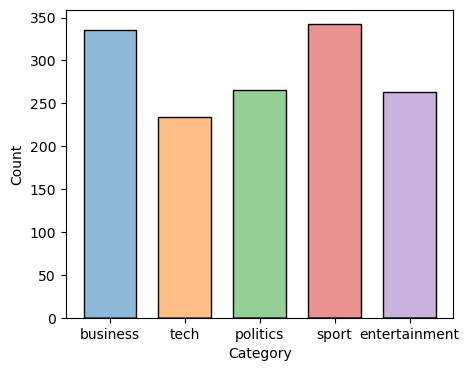

In [128]:
plt.figure(figsize=(5, 4))
sns.histplot(train, x='Category', hue='Category', shrink=0.7, legend=False);

In [81]:
n_majority_class = class_counts.loc['sport']
n_minority_class = class_counts.loc['tech']
imbalanced_ratio = n_majority_class / n_minority_class
imbalanced_ratio

1.4615384615384615

If the imbalance ratio is close to 1, it indicates a more balanced dataset. We will conclude that our data is roughly balanced.
### Word Count Statistics

In [6]:
train_stats = train[['Text', 'Category']]
train_stats['word_count'] = train_stats.Text.apply(lambda x: len(x.split()))

In [9]:
train_stats[['Category', 'word_count']].groupby('Category').describe()

word_count                                                \
                   count        mean         std    min     25%    50%   
Category                                                                 
business           335.0  334.274627  133.713125  145.0  253.00  304.0   
entertainment      263.0  335.444867  207.134549  144.0  229.00  271.0   
politics           266.0  451.642857  261.490785   90.0  320.25  445.0   
sport              342.0  336.877193  185.930006  116.0  211.50  296.5   
tech               234.0  509.222222  212.922747  188.0  345.25  461.5   

                               
                  75%     max  
Category                       
business       391.50   902.0  
entertainment  380.00  2448.0  
politics       527.75  3345.0  
sport          416.75  1671.0  
tech           633.75  1549.0

Tech articles have the highest average word count per article (509.22). Its word_count distribution is skewed to the right as can be seen on the plot below.

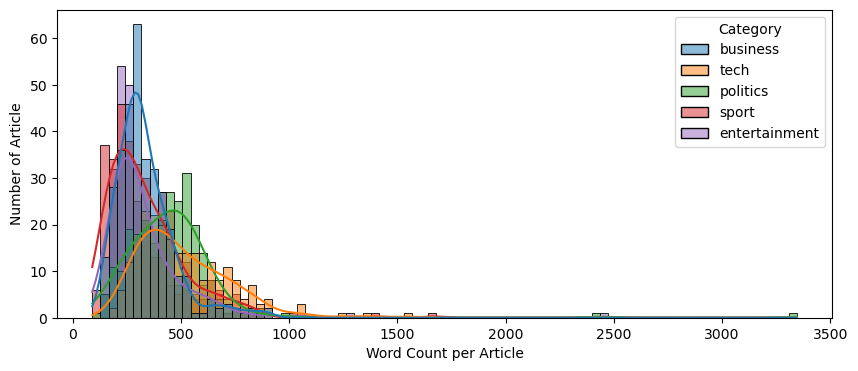

In [13]:
plt.figure(figsize=(10, 4))
sns.histplot(train_stats, x='word_count', hue='Category', kde=True)
plt.xlabel('Word Count per Article')
plt.ylabel('Number of Article');

### Create labels for Category

In [15]:
label_names = train.Category.unique().tolist()
label_names

['business', 'tech', 'politics', 'sport', 'entertainment']

In [16]:
mapping = dict(zip(label_names, list(range(5))))
mapping

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

In [17]:
train['labels'] = [mapping[c] for c in train.Category]
train.tail()

,ArticleId,Text,Category,labels
1435,857,double eviction from big brother model caprice...,entertainment,4
1436,325,dj double act revamp chart show dj duo jk and ...,entertainment,4
1437,1590,weak dollar hits reuters revenues at media gro...,business,0
1438,1587,apple ipod family expands market apple has exp...,tech,1
1439,538,santy worm makes unwelcome visit thousands of ...,tech,1


**Assign training labels (Category) to variable y**, it will used later for performance metric in unsupervised learning.

In [18]:
y = train.labels.tolist()

### Turning Text into numbers
Part of the difficulty of machine learning with text is turning language into numbers. One of the most straightforward ways to do this for documents is what is known as the “bag-of-words” model. In this model we view a document as simply a multi-set of the words contained in it – we completely ignore word order. The result can be viewed as a matrix of data by setting the feature space to be the set of all words that appear in any document, and a document is represented by a vector where the value of the ith entry is the number of times the ith word occurs in that document. This is what we will get if we apply Sklearn TfidfVectorizer to a text data.

The **Term Frequency-Inverse Document Frequency (TF-IDF)** is a numerical statistic used to reflect the importance of a term in a document relative to a collection of documents (corpus). The TF-IDF value increases proportionally to the number of times a term appears in a document but is offset by the frequency of the term in the corpus.

The TF-IDF formula for a term t in a document d:

$$TF\text{-}IDF(t, d) = TF(t, d) × IDF(t)$$

where:
* TF(t, d) is the Term Frequency of term t in document d, which measures how often t appears in d
$$TF(t, d) = \frac{Number\;of\;times\;term\;t\;appears\;in\;document\;d}{Total\;number\;of\;terms\;in\;document\;d}$$
<br>
* IDF(t) is the Inverse Document Frequency of term t, which measures the importance of t in the entire corpus.
$$IDF(t) = \log\left({\frac{Total\;number\;of\;documents\;in\;the\;corpus}{1 + Number\;of\;documents\;containing\;term\;t}}\right) + 1$$

The +1 in the denominator of IDF is for smoothing, which helps avoid division by zero when a term is present in all documents.

The TF-IDF value gives higher weight to terms that are frequent in the document but rare in the corpus,

### Sklearn TfidfVectorizer
**param: smooth_idf**

If smooth_idf is set to True, the formula for computing the IDF is modified by adding 1 to the document frequency and 1 to the denominator. This helps prevent division by zero when a term is present in all documents. By default, smooth_idf is set to True in scikit-learn's TfidfVectorizer.

**param: min_df**
* If min_df=2, a term must appear in at least 2 documents to be considered.

**param: max_df**
* If max_df is a float between 0 and 1, it represents the maximum fraction of documents in which a term can appear. For example: max_df=0.9, in this case, a term must not be present in more than 90% of the documents to be included.

**param: ngram_range**
* unigram is a single word sequence of words like “please” or “ turn”.
* bigram is a two-word sequence of words like “please turn” or ”your homework”.
* (1, 2) means unigrams and bigrams

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# DTM: Document Term Matrix
DTM = tfidf_vectorizer.fit_transform(train.Text)

feature_names = tfidf_vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(DTM.toarray(), columns=feature_names)
print('Document Term Matrix size:', DTM_df.shape)
DTM_df.head()

Document Term Matrix size: (1440, 13752)


,00,000,000m,000th,007,01,0100,0130,028,03,...,zoe,zola,zombie,zombies,zone,zones,zoom,zooms,zurich,zvonareva
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.024543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.019484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Different parameters in TfidfVectorizer resulted in a different Document Term Matrix size.

In [8]:
tfidf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english', sublinear_tf=True)

# DTM: Document Term Matrix
DTM = tfidf_vectorizer.fit_transform(train.Text)

feature_names = tfidf_vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(DTM.toarray(), columns=feature_names)
print('Document Term Matrix size:', DTM_df.shape)
DTM_df.head()

Document Term Matrix size: (1440, 40885)


,00,000,000 100,000 133,000 20,000 2005,000 30,000 according,000 acre,000 amicus,...,zombies,zone,zone georgewbush,zones,zoom,zooms,zooms likely,zurich,zurich premiership,zvonareva
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.026269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.016212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
sparsity = (DTM_df.values == 0).sum() / (DTM_df.shape[0] * DTM_df.shape[1])
print('The Document Term Matrix degree of sparsity is {}%'.format(round(sparsity*100, 2)))

The Document Term Matrix degree of sparsity is 99.53%


### UMAP: Uniform Manifold Approximation and Projection to 2 Dimension
We can pass this very high dimensional data (DTM) to UMAP, it will reduce the data to a dense numpy array, that we can plot.

In [9]:
from umap import UMAP

In [10]:
embedding = UMAP(metric='hellinger', n_neighbors=5, random_state=0, n_jobs=1).fit_transform(DTM)

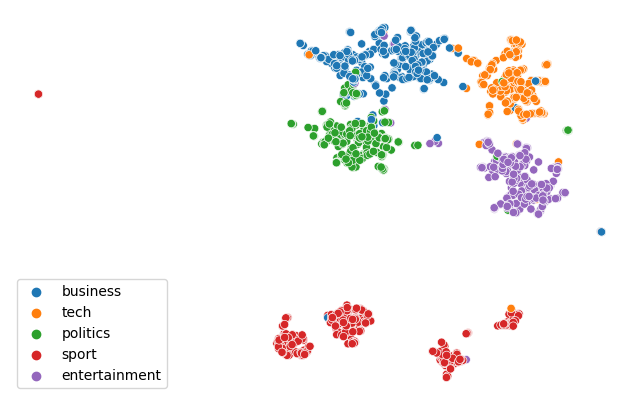

In [39]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=train.Category.tolist())
plt.axis('off');

We went from a 40885 (DTM.shape[1]) dimensional space down to only 2 dimensions. UMAP has done a decent job of separating out the 5 different categories.

## 2. Building and training models
### Unsupervised Learning
### Sklearn Non-Negative Matrix Factorization (NMF)

Approximate the non-negative matrix X with a product of two non-negative matrices, i.e. matrices with all non-negative elements (W, H). This model is suitable for our Text/word counts data with non-negative entries.

We will start off with an NMF model that has Frobenius loss as the objective function. 

We will find out later that KL ("kullback-leibler") loss  is actually more suitable for our data.

In [224]:
model_nmf = NMF(n_components=5, init='nndsvd', beta_loss='frobenius', solver='cd', max_iter=200).fit(DTM)
W = model_nmf.transform(DTM)
H = model_nmf.components_

Next, we will plot the top feature names, i.e. top words, from each of the 5 components (we'll call them Topic 1 to 5). We can get them from the H matrix, the model components_. As mentioned in the lecture, this matrix H are the weights, we will sort the weights and get the largest indices, and these are indices of the top feature names.

In [91]:
def plot_top_features(H, feature_names):
    plt.figure(figsize=(24, 16))
    for i, topic in enumerate(H):
        plt.subplot(231+i)
        top_features_ind = topic.argsort()[-20:]
        top_features_names = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        plt.barh(top_features_names, weights, height=0.7)
        plt.yticks(fontsize=16)
        plt.title(f'Topic {i+1}', fontsize=24)
    plt.tight_layout()

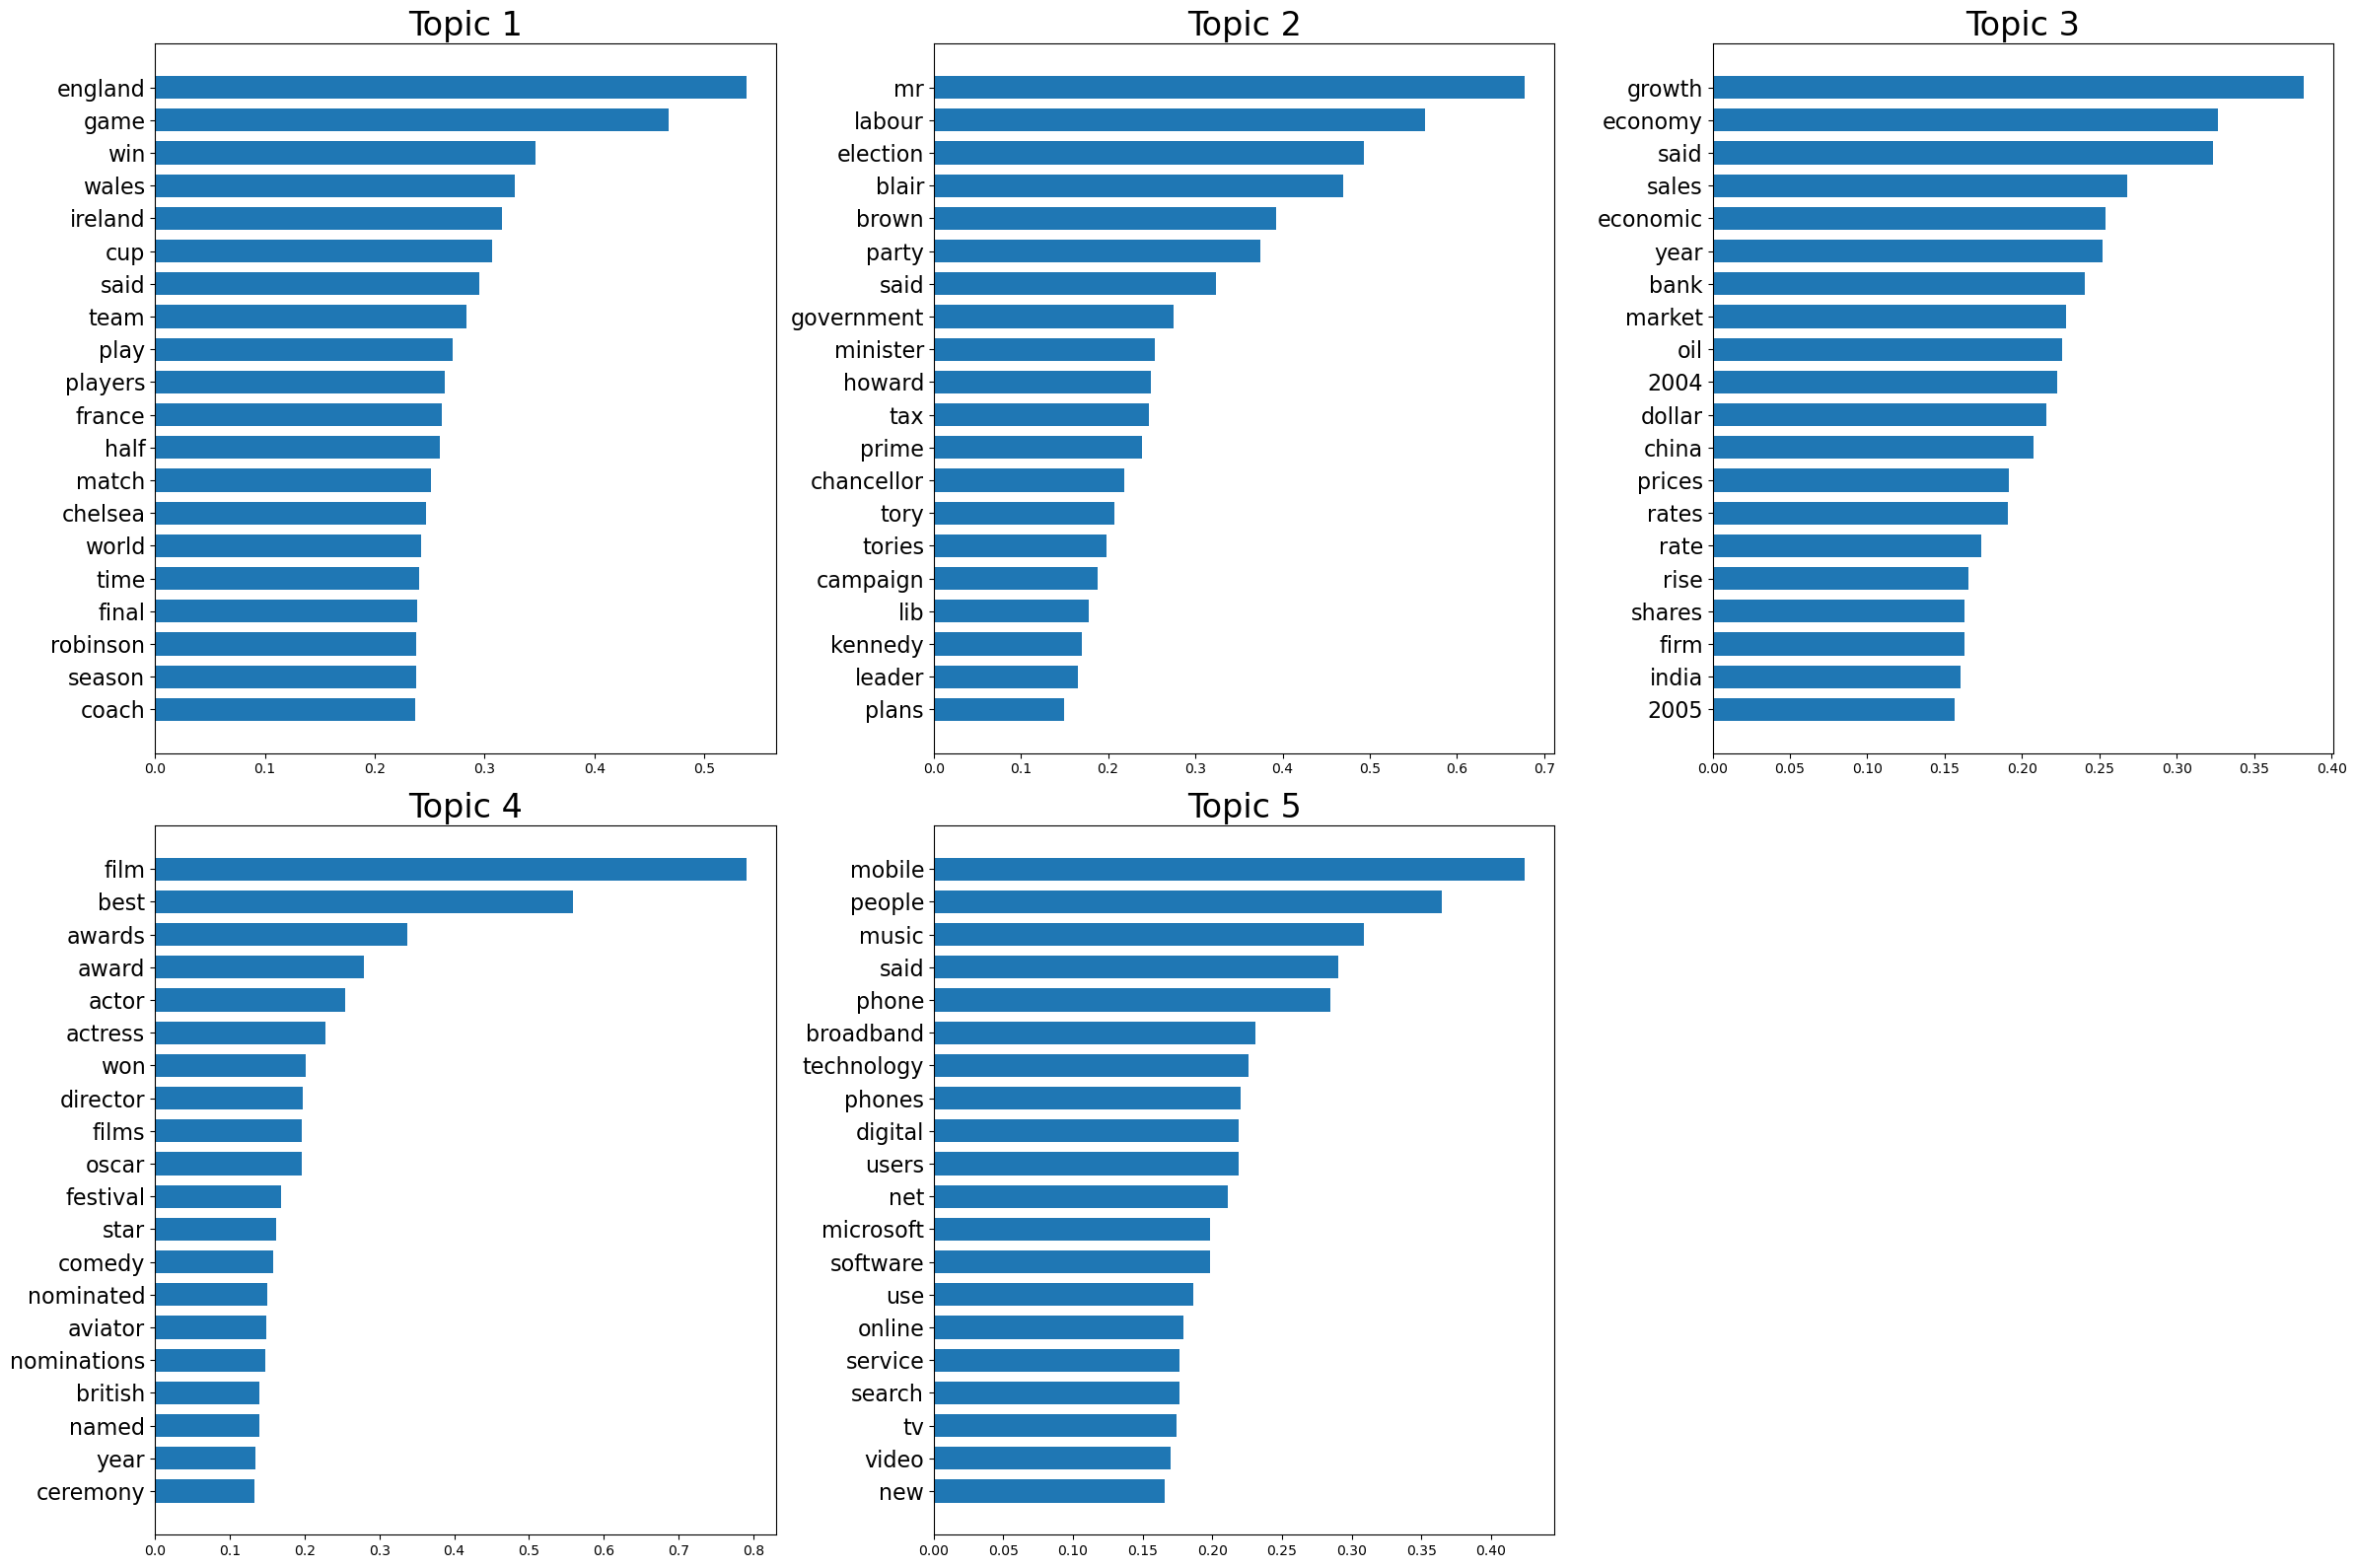

In [92]:
plot_top_features(H, feature_names)

We can easily guess from the plot of the most important feature names (words) on each Topic, which category a topic belongs to. Our NMF model has done a decent job separating out words into their categories.

### Predict Labels

In [217]:
pd.DataFrame(W).head()

,0,1,2,3,4
0,0.000654,0.041107,0.047912,0.002888,0.009880
1,0.000000,0.000000,0.210681,0.000000,0.000000
2,0.014364,0.023132,0.116876,0.001854,0.028428
3,0.000000,0.000000,0.000000,0.000000,0.233291
4,0.005919,0.006048,0.070280,0.007946,0.012129


In [225]:
predictions = np.argmax(W, axis=1)

In [20]:
BEST_ORDERING = None

def label_permute_compare(y, yp):  
    unique_labels = np.unique(yp)
    ordering = permutations(unique_labels)    
    best_accuracy = 0.0
    global BEST_ORDERING
    
    for order in ordering:
        # Create a mapping of yp according to order
        label_mapping = dict(zip(unique_labels, order))
        reordered_yp = np.array([label_mapping[lbl] for lbl in yp])
        
        curr_score = accuracy_score(y, reordered_yp)
        if curr_score > best_accuracy:
            best_accuracy = curr_score
            BEST_ORDERING = order
            
    return best_accuracy

In [227]:
print('Accuracy score for NMF model with beta_loss="frobenius":')
label_permute_compare(y, predictions)

Accuracy score for NMF model with beta_loss="frobenius":


0.9104166666666667

### Hyperparameter Tuning
As mentioned in the lecture on NMF, the non-negative matrix X is approximated by the product of 2 matrices W and H.
* If we assumed random variable $X_{i,j}$ follows a Gaussian Distribution, then we get the L2 loss (squared loss).
* If we assumed random variable $X_{i,j}$ follows a Laplace Distribution, then we get the L1 loss.

If $x_{i,j}$ is close to zero, their errors can be $\pm \; \varepsilon \text{~} N(0, \sigma)$ for L2 loss. Same thing with L1 loss, it may lead to a negative result. This can be a problem since our data is very sparse. The Document Term Matrix output from TfidfVectorizer has 99% sparsity. 

KL ('kullback-leibler') loss can be obtained by modeling our random variable to be Poisson Distribution. This is more suitable for our sparse data.

**Note**: solver 'cd' does not handle beta_loss = 'kullback-leibler', we will use 'mu', Multiplicative Update solver.

Since NMF model does not have the predict method, we will have to create our own custom scoring function, this way, we can evaluate the performances of our models.

In [30]:
def custom_scoring(estimator, X, y):
    W = estimator.transform(X)
    predictions = np.argmax(W, axis=1)
    return label_permute_compare(y, predictions)

In [31]:
pipe = Pipeline([
    ('tfidfvectorizer', TfidfVectorizer(stop_words='english', sublinear_tf=True)),
    ('nmf', NMF(n_components=5, beta_loss='kullback-leibler', solver='mu', init='nndsvda', random_state=0))
])

params = [{
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)], 
    'tfidfvectorizer__min_df': [2, 5],
    'nmf__alpha_W': [0, 0.01, 0.05],
    'nmf__alpha_H': [0, 0.01, 0.05]
}]

In [32]:
t0 = time.time()

grid_search = GridSearchCV(pipe, param_grid=params, scoring=custom_scoring, cv=5)
X = train.Text
y = train.labels
grid_search.fit(X, y)

elapsed_time = (time.time() - t0)/60
print('Grid Search CV evaluation in {} minutes'.format(round(elapsed_time, 2)))

Grid Search CV evaluation in 9.9 minutes


In [33]:
pd.set_option('display.max_colwidth', None)
res = pd.DataFrame(grid_search.cv_results_)

In [44]:
res.iloc[:, [8, 14, 15, 16]].sort_values(by='rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
21,"{'nmf__alpha_H': 0.01, 'nmf__alpha_W': 0.05, 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__ngram_range': (1, 2)}",0.968056,0.010159,1
33,"{'nmf__alpha_H': 0.05, 'nmf__alpha_W': 0.05, 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__ngram_range': (1, 2)}",0.966667,0.010206,2
7,"{'nmf__alpha_H': 0, 'nmf__alpha_W': 0.01, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2)}",0.966667,0.008947,2
19,"{'nmf__alpha_H': 0.01, 'nmf__alpha_W': 0.01, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2)}",0.966667,0.013466,2
31,"{'nmf__alpha_H': 0.05, 'nmf__alpha_W': 0.01, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2)}",0.965972,0.014633,5
3,"{'nmf__alpha_H': 0, 'nmf__alpha_W': 0, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2)}",0.965972,0.013249,5
23,"{'nmf__alpha_H': 0.01, 'nmf__alpha_W': 0.05, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2)}",0.965972,0.014633,5
11,"{'nmf__alpha_H': 0, 'nmf__alpha_W': 0.05, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2)}",0.965972,0.010159,5
35,"{'nmf__alpha_H': 0.05, 'nmf__alpha_W': 0.05, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2)}",0.964583,0.012880,9
27,"{'nmf__alpha_H': 0.05, 'nmf__alpha_W': 0, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2)}",0.963194,0.011744,10


In [45]:
pd.reset_option('display.max_colwidth')

print('GridSearchCV best parameters:')
grid_search.best_params_

GridSearchCV best parameters:


{'nmf__alpha_H': 0.01,
 'nmf__alpha_W': 0.05,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 2)}

### Best NMF Model
Train model with parameter values based on GridSearchCV result, on the training word embedding (the Document Term Matrix). We will train the model on the train data, not including the test data. Training model on the whole dataset (train plus test) will overfit the model, it will not generalized well to unseen data.

In [21]:
tfidf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english', sublinear_tf=True)

# DTM: Document Term Matrix
DTM = tfidf_vectorizer.fit_transform(train.Text)

model_nmf = NMF(n_components=5, beta_loss='kullback-leibler', solver='mu', init='nndsvda', 
                alpha_W=0.05, alpha_H=0.01, random_state=0)

W = model_nmf.fit_transform(DTM)
H = model_nmf.components_

predictions = np.argmax(W, axis=1)
y = train.labels
print('Accuracy score of the best NMF model:', round(label_permute_compare(y, predictions), 3))

Accuracy score of the best NMF model: 0.969


In [22]:
# use BEST_ORDERING that was assigned the best labelorder in label_permute_compare(), to map predictions
unique_labels = np.unique(predictions)
label_mapping = dict(zip(unique_labels, BEST_ORDERING))
reordered_yp = np.array([label_mapping[lbl] for lbl in predictions])

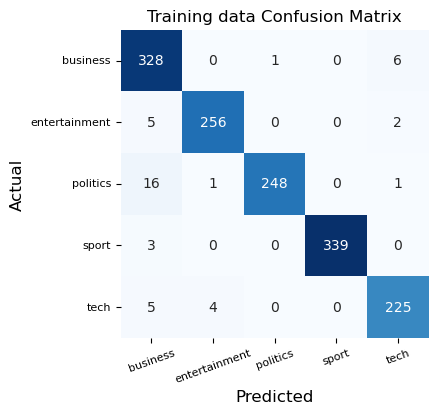

In [23]:
# plot confusion matrix
levels = pd.Index(label_names)
cm = pd.crosstab(levels[y], levels[reordered_yp])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='.0f', cbar=False)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=20, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Training data Confusion Matrix');

### Test Data Preprocesing and Predictions

In [24]:
DTM_test = tfidf_vectorizer.transform(test.Text)

test_W = model_nmf.transform(DTM_test)
test_predictions = np.argmax(test_W, axis=1)

reordered_test_predictions = np.array([label_mapping[lbl] for lbl in test_predictions])
test_predicted_labels = levels[reordered_test_predictions]

In [26]:
submission = pd.DataFrame({'ArticleId': test['ArticleId'],
                           'Category': test_predicted_labels})
submission

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,politics
733,206,business


Kaggle submisson accuracy score from Unsupervised learning - NMF model:

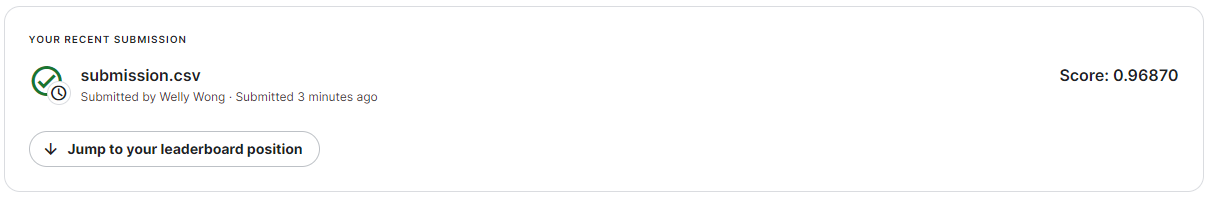

## 3. Compare with Supervised Learning
We will train 3 supersived learning models: KNN, Multinomial Naive Bayes and Logistic Regression Classifiers. Then compare their performances using accuracy metric before deciding on the final model.

In [60]:
models = [KNeighborsClassifier(n_neighbors=5),
          MultinomialNB(alpha=0.01),           # alpha: Laplace smoothing, added to avoid zero probabilities
          LogisticRegression(penalty='l2', class_weight='balanced', multi_class='multinomial', random_state=0)]

# K-fold defines number of fold and is used for shuffling data
kf = KFold(n_splits=10, shuffle=True, random_state=0)

cross_val_result = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, DTM, train.Category, scoring='accuracy', cv=kf)
    for fold_idx, accuracy in enumerate(accuracies):
        cross_val_result.append((model_name, fold_idx, accuracy))

In [64]:
res = pd.DataFrame(cross_val_result, columns=['Classifier', 'Folds', 'Accuracy'])
res.groupby('Classifier', as_index=False)['Accuracy'].mean()

,Classifier,Accuracy
0,KNeighborsClassifier,0.968056
1,LogisticRegression,0.975694
2,MultinomialNB,0.981250


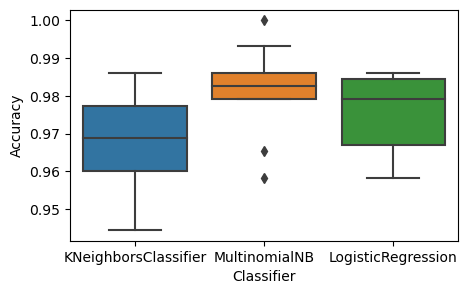

In [63]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=res, x='Classifier', y='Accuracy');

We will use **Multinomial Naive Bayes as our final model** based on cross_val_score results of the 3 models that we tested.

### Training the final model with train data

### Multinomial Naive Bayes

In [56]:
tfidf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english', sublinear_tf=True)

# DTM: Document Term Matrix
DTM_train = tfidf_vectorizer.fit_transform(train.Text)
DTM_test = tfidf_vectorizer.transform(test.Text)

In [58]:
model_final = MultinomialNB(alpha=0.01)
model_final.fit(DTM_train, train.Category)

# predict the training data
y_pred_train = model_final.predict(DTM_train)
print('Multinomial Naive Bayes accuracy score on the training data (alpha=0.01):', accuracy_score(y_pred_train, train.Category))

Multinomial Naive Bayes accuracy score on the training data (alpha=0.01): 1.0


We have an accuracy score of 1 on the training set, it suggests that our model may be overfitting. It's possible that the alpha value is too low. We will increase alpha from 0.01 to 0.1

In [59]:
model_final = MultinomialNB(alpha=0.1)
model_final.fit(DTM_train, train.Category)

y_pred_train = model_final.predict(DTM_train)
print('Multinomial Naive Bayes accuracy score on the training data (alpha=0.1):', accuracy_score(y_pred_train, train.Category))

Multinomial Naive Bayes accuracy score on the training data (alpha=0.1): 0.9986111111111111


Multinomial Naive Bayes model on the test data. Submission result:

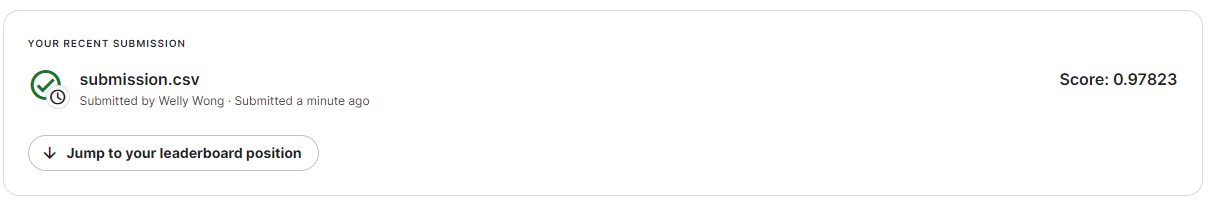

### Logistic Regression

In [60]:
model_final = LogisticRegression(penalty='l2', class_weight='balanced', multi_class='multinomial', random_state=0)
model_final.fit(DTM_train, train.Category)

# predict the training data
y_pred_train = model_final.predict(DTM_train)
print('Logistic Regression model accuracy score on the training data:', accuracy_score(y_pred_train, train.Category))

Logistic Regression model accuracy score on the training data: 0.9979166666666667


Logistic Regression model on the test data. Submission result:

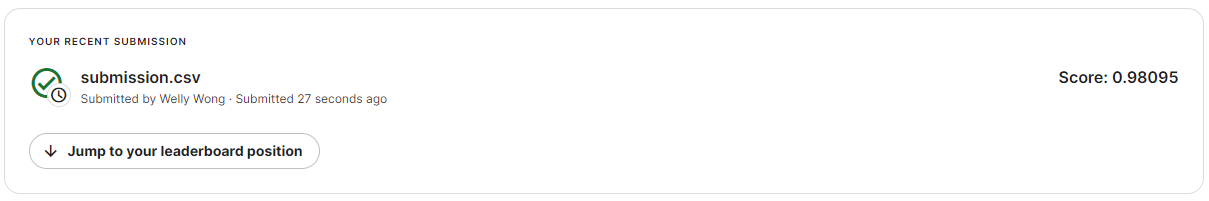

### Stacking Classifier

In [61]:
from sklearn.ensemble import StackingClassifier

In [62]:
classifiers = [
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('MultinomialNB', MultinomialNB(alpha=0.01))
]

clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(penalty='l2', class_weight='balanced', 
                                                                                    multi_class='multinomial', random_state=0))

In [63]:
clf.fit(DTM_train, train.Category)

y_pred_train = clf.predict(DTM_train)

print('Stacking Classifier accuracy score on the training data:', accuracy_score(y_pred_train, train.Category))

Stacking Classifier accuracy score on the training data: 0.9993055555555556


Stacking Classifier resulted in lower accuracy score on the test data. This is likely due to overfitting the model.

Submission result:

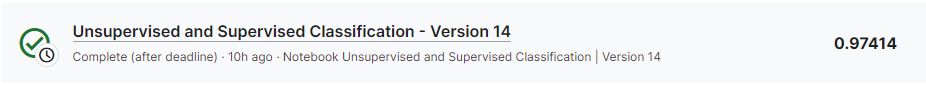

### Comparison with Unsupervised approach

Our best Unsupersived Learning model (NMF) has an accuracy score of 0.96870 compared to the best Supervised Learning model (Logistic Regression) accuracy score of 0.98095. In term of accuracy, the supervised learning performs better.

Next, we will look at the logistic regression model performances with only 10%, 20% and 50% of training labels.

We will group our training set by 'Category' and then, within each group, randomly sample 10% of the rows. The resulting data includes a subset of the original data, with 10% of rows sampled from each 'Category' group.

In [143]:
train_set, valid_set, train_label, valid_label = train_test_split(train, y, test_size=0.2, random_state=42)

In [147]:
frac_labels = [0.1, 0.2, 0.5, 0.7, 0.9, 1.0]
accuracy_scores_train = []
accuracy_scores_valid = []

for frac_label in (frac_labels):
    # grouped random sampling
    train_set_pct = train_set.groupby('Category', group_keys=False).apply(lambda x: x.sample(frac=frac_label)).copy()
    
    # preprocess train_set_pct Text
    # initialize tfidf vectorizer
    tfidf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english', sublinear_tf=True)

    # fit tfidf vectorizer to the train_set_pct
    DTM_train_set = tfidf_vectorizer.fit_transform(train_set_pct.Text)
    DTM_valid_set = tfidf_vectorizer.transform(valid_set.Text)
    
    # fit model and predictions
    model = LogisticRegression(penalty='l2', class_weight='balanced', multi_class='multinomial', random_state=0)
    model.fit(DTM_train_set, train_set_pct.labels.tolist())

    # predict the training set
    y_pred_train = model.predict(DTM_train_set)
    acc = accuracy_score(y_pred_train, train_set_pct.labels.tolist())
    accuracy_scores_train.append(acc)

    # predict the validation set
    y_pred_valid = model.predict(DTM_valid_set)
    acc = accuracy_score(y_pred_valid, valid_set.labels.tolist())
    accuracy_scores_valid.append(acc)

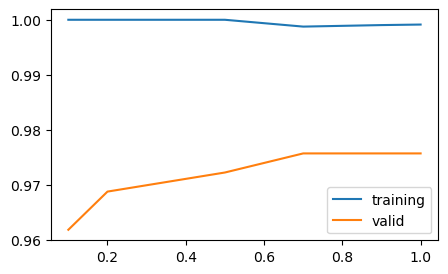

In [152]:
plt.figure(figsize=(5, 3))
plt.plot(frac_labels, accuracy_scores_train, label='training')
plt.plot(frac_labels, accuracy_scores_valid, label='valid')
plt.legend();

We observed from the plot that the validation accuracy score improved as we increased the percentage of training labels. It peaked at around 70% of training labels. This suggests that we can achieve similar results using only 70% of the data. The supervised learning approach is more data-efficient.

Logistic regression has predict_proba method that provides the predicted probabilities for each class. These probabilities represent the model's confidence in assigning a given instance to each class. While matrix factorization may provide latent factors that are harder to interpret.

### Kaggle Submission

In [77]:
y_pred_test = model_final.predict(DTM_test)

In [78]:
submission = pd.DataFrame({'ArticleId': test['ArticleId'],
                           'Category': y_pred_test})

In [79]:
submission

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,politics
733,206,business


### Reference
* https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification
* Geena Kim: Lecture Notes on Non-Negative Matrix Factorization (NMF)
* Vector 5 TF IDF - From Languages to Information: https://www.youtube.com/watch?v=TBUpxFw8oIA
* https://umap-learn.readthedocs.io/_/downloads/en/0.4dev/pdf/
* https://www.kaggle.com/code/aryankaul31/aryan-bbc-news-classification
* Quan Nguyen: Naive Bayes and Hyperparameter Optimization: https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html